In [1]:
# Loading the required libraries
import itertools
import pandas as pd
import numpy as np
import re
import os
from scipy import sparse
from tqdm import tqdm

# Visualizing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
# Defining the various functions
def create_unique_word_dict(text: list) -> dict:
    '''
    A method that create a dictionary where the keys are unique words and key values are indices
    '''
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()
    
    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({word : i})
    return unique_word_dict

In [3]:
def text_preprocessing(text: list, 
                      punctuations = r'!()-[]{};:"''\<>.,?/@#$%*_~',
                      stop_words = ['and', 'a', 'is', 'the', 'in', 'be', 'will']) -> list:
    '''
    A method to preprocess text
    '''
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")
            
    # removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)
    
    # removing digits
    text = re.sub(r'[0-9]+', '', text)
    
    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # setting every word to lower
    text = text.lower()
    
    # converting all our text to a list
    text = text.split(' ')
    
    # dropping empty strings
    text = [x for x in text if x!= '']
    
    # dropping stop words
    text = [x for x in text if x not in stop_words]
    
    return text

In [4]:
# Functions to find the most similar words
def euclidean(vec1: np.array, vec2: np.array) -> float:
    '''
    A function to calculate the euclidean distance between two vectors
    '''
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

In [5]:
def find_similar(word: str, embedding_dict: dict, top_n = 10) -> list:
    '''
    A method to find the most similar word based on the learnt embeddings
    '''
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key != word:
                dist = euclidean(word_vector, value)
                dist_dict.update({key: dist})
                
        return sorted(dist_dict.items(), key = lambda x: x[1][0: top_n])

In [6]:
# Loading the dataset
texts = pd.read_csv(r"input\sample.csv")
texts

,text
0,The future king is the prince
1,Daughter is the princess
2,Son is the prince
3,Only a man can be a king
4,Only a woman can be a queen
5,The princess will be a queen
6,Queen and king rule the realm
7,The prince is a strong man
8,The princess is a beautiful woman
9,The royal family is the king and queen and the...


In [7]:
texts = [x for x in texts['text']]
texts

['The future king is the prince',
 'Daughter is the princess ',
 'Son is the prince',
 'Only a man can be a king ',
 'Only a woman can be a queen',
 'The princess will be a queen',
 'Queen and king rule the realm',
 'The prince is a strong man',
 'The princess is a beautiful woman ',
 'The royal family is the king and queen and their children',
 'Prince is only a boy now',
 'A boy will be a man']

In [8]:
# Defining the window for context
window = 2
# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:
    # Cleaning the text
    print('\nOriginal Text: ', text)
    text = text_preprocessing(text)
    print('Cleaned Text: ', text)
    # Appending to the all text list
    all_text += text 
    
    print("Enumerated data")
    # Creating a context dictionary
    for i, word in enumerate(text):
        print(".....i....." , i, "....word....", word)
        for w in range(3):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])


Original Text:  The future king is the prince
Cleaned Text:  ['future', 'king', 'prince']
Enumerated data
.....i..... 0 ....word.... future
.....i..... 1 ....word.... king
.....i..... 2 ....word.... prince

Original Text:  Daughter is the princess 
Cleaned Text:  ['daughter', 'princess']
Enumerated data
.....i..... 0 ....word.... daughter
.....i..... 1 ....word.... princess

Original Text:  Son is the prince
Cleaned Text:  ['son', 'prince']
Enumerated data
.....i..... 0 ....word.... son
.....i..... 1 ....word.... prince

Original Text:  Only a man can be a king 
Cleaned Text:  ['only', 'man', 'can', 'king']
Enumerated data
.....i..... 0 ....word.... only
.....i..... 1 ....word.... man
.....i..... 2 ....word.... can
.....i..... 3 ....word.... king

Original Text:  Only a woman can be a queen
Cleaned Text:  ['only', 'woman', 'can', 'queen']
Enumerated data
.....i..... 0 ....word.... only
.....i..... 1 ....word.... woman
.....i..... 2 ....word.... can
.....i..... 3 ....word.... queen

Or

In [9]:
print("word list " , word_lists)

word list  [['future', 'king'], ['future', 'prince'], ['king', 'prince'], ['king', 'future'], ['prince', 'king'], ['prince', 'future'], ['daughter', 'princess'], ['princess', 'daughter'], ['son', 'prince'], ['prince', 'son'], ['only', 'man'], ['only', 'can'], ['only', 'king'], ['man', 'can'], ['man', 'only'], ['man', 'king'], ['can', 'king'], ['can', 'man'], ['can', 'only'], ['king', 'can'], ['king', 'man'], ['king', 'only'], ['only', 'woman'], ['only', 'can'], ['only', 'queen'], ['woman', 'can'], ['woman', 'only'], ['woman', 'queen'], ['can', 'queen'], ['can', 'woman'], ['can', 'only'], ['queen', 'can'], ['queen', 'woman'], ['queen', 'only'], ['princess', 'queen'], ['queen', 'princess'], ['queen', 'king'], ['queen', 'rule'], ['queen', 'realm'], ['king', 'rule'], ['king', 'queen'], ['king', 'realm'], ['rule', 'realm'], ['rule', 'king'], ['rule', 'queen'], ['realm', 'rule'], ['realm', 'king'], ['realm', 'queen'], ['prince', 'strong'], ['prince', 'man'], ['strong', 'man'], ['strong', 'pr

In [10]:
unique_word_dict = create_unique_word_dict(all_text)
print("unique_word_dict",unique_word_dict)

unique_word_dict {'beautiful': 0, 'boy': 1, 'can': 2, 'children': 3, 'daughter': 4, 'family': 5, 'future': 6, 'king': 7, 'man': 8, 'now': 9, 'only': 10, 'prince': 11, 'princess': 12, 'queen': 13, 'realm': 14, 'royal': 15, 'rule': 16, 'son': 17, 'strong': 18, 'their': 19, 'woman': 20}


In [11]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)
n_words

21

In [12]:
# Getting all the unique words 
words = list(unique_word_dict.keys())
print("words", words)

words ['beautiful', 'boy', 'can', 'children', 'daughter', 'family', 'future', 'king', 'man', 'now', 'only', 'prince', 'princess', 'queen', 'realm', 'royal', 'rule', 'son', 'strong', 'their', 'woman']


In [13]:
# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    print("......i....." ,i,"....word_list....", word_list , "\nword_list[0]:", word_list[0], "| word_list[1]: ",word_list[1])
    
    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

98it [00:00, 5172.09it/s]

......i..... 0 ....word_list.... ['future', 'king'] 
word_list[0]: future | word_list[1]:  king
......i..... 1 ....word_list.... ['future', 'prince'] 
word_list[0]: future | word_list[1]:  prince
......i..... 2 ....word_list.... ['king', 'prince'] 
word_list[0]: king | word_list[1]:  prince
......i..... 3 ....word_list.... ['king', 'future'] 
word_list[0]: king | word_list[1]:  future
......i..... 4 ....word_list.... ['prince', 'king'] 
word_list[0]: prince | word_list[1]:  king
......i..... 5 ....word_list.... ['prince', 'future'] 
word_list[0]: prince | word_list[1]:  future
......i..... 6 ....word_list.... ['daughter', 'princess'] 
word_list[0]: daughter | word_list[1]:  princess
......i..... 7 ....word_list.... ['princess', 'daughter'] 
word_list[0]: princess | word_list[1]:  daughter
......i..... 8 ....word_list.... ['son', 'prince'] 
word_list[0]: son | word_list[1]:  prince
......i..... 9 ....word_list.... ['prince', 'son'] 
word_list[0]: prince | word_list[1]:  son
......i.....

In [14]:
# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

In [15]:
# Defining the size of the embedding
embed_size = 2

In [16]:
# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [17]:
# Optimizing the network weights
model.fit(x = X, y = Y, batch_size = 250, epochs = 1000)

Epoch 1/1000
98/98 [==============================] - 0s 448us/step - loss: 3.0620
Epoch 2/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0609
Epoch 3/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0599
Epoch 4/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0588
Epoch 5/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0578
Epoch 6/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0567
Epoch 7/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0557
Epoch 8/1000
98/98 [==============================] - 0s 31us/step - loss: 3.0547
Epoch 9/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0536
Epoch 10/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0526
Epoch 11/1000
98/98 [==============================] - 0s 10us/step - loss: 3.0515
Epoch 12/1000
98/98 [==============================] - 0s 20us/step - loss: 3.0505
Epoch 13/100

Epoch 100/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9659
Epoch 101/1000
98/98 [==============================] - 0s 20us/step - loss: 2.9650
Epoch 102/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9641
Epoch 103/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9631
Epoch 104/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9622
Epoch 105/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9613
Epoch 106/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9603
Epoch 107/1000
98/98 [==============================] - 0s 20us/step - loss: 2.9594
Epoch 108/1000
98/98 [==============================] - 0s 20us/step - loss: 2.9585
Epoch 109/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9575
Epoch 110/1000
98/98 [==============================] - 0s 10us/step - loss: 2.9566
Epoch 111/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 198/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8726
Epoch 199/1000
98/98 [==============================] - 0s 20us/step - loss: 2.8717
Epoch 200/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8707
Epoch 201/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8697
Epoch 202/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8688
Epoch 203/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8678
Epoch 204/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8669
Epoch 205/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8659
Epoch 206/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8650
Epoch 207/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8640
Epoch 208/1000
98/98 [==============================] - 0s 10us/step - loss: 2.8631
Epoch 209/1000
98/98 [==============================] - 0s 20us/step - loss:

Epoch 296/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7810
Epoch 297/1000
98/98 [==============================] - 0s 20us/step - loss: 2.7801
Epoch 298/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7792
Epoch 299/1000
98/98 [==============================] - 0s 20us/step - loss: 2.7783
Epoch 300/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7774
Epoch 301/1000
98/98 [==============================] - 0s 20us/step - loss: 2.7764
Epoch 302/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7755
Epoch 303/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7746
Epoch 304/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7737
Epoch 305/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7728
Epoch 306/1000
98/98 [==============================] - 0s 10us/step - loss: 2.7719
Epoch 307/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 394/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6916
Epoch 395/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6907
Epoch 396/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6898
Epoch 397/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6889
Epoch 398/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6880
Epoch 399/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6871
Epoch 400/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6861
Epoch 401/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6852
Epoch 402/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6843
Epoch 403/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6834
Epoch 404/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6825
Epoch 405/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 492/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6053
Epoch 493/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6044
Epoch 494/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6036
Epoch 495/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6028
Epoch 496/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6020
Epoch 497/1000
98/98 [==============================] - 0s 20us/step - loss: 2.6012
Epoch 498/1000
98/98 [==============================] - 0s 10us/step - loss: 2.6004
Epoch 499/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5996
Epoch 500/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5988
Epoch 501/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5979
Epoch 502/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5971
Epoch 503/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 590/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5339
Epoch 591/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5333
Epoch 592/1000
98/98 [==============================] - 0s 20us/step - loss: 2.5327
Epoch 593/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5320
Epoch 594/1000
98/98 [==============================] - 0s 20us/step - loss: 2.5314
Epoch 595/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5308
Epoch 596/1000
98/98 [==============================] - 0s 20us/step - loss: 2.5302
Epoch 597/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5295
Epoch 598/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5289
Epoch 599/1000
98/98 [==============================] - 0s 10us/step - loss: 2.5283
Epoch 600/1000
98/98 [==============================] - 0s 20us/step - loss: 2.5277
Epoch 601/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 688/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4801
Epoch 689/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4796
Epoch 690/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4791
Epoch 691/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4787
Epoch 692/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4782
Epoch 693/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4777
Epoch 694/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4773
Epoch 695/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4768
Epoch 696/1000
98/98 [==============================] - 0s 20us/step - loss: 2.4763
Epoch 697/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4759
Epoch 698/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4754
Epoch 699/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 786/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4398
Epoch 787/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4395
Epoch 788/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4391
Epoch 789/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4388
Epoch 790/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4384
Epoch 791/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4381
Epoch 792/1000
98/98 [==============================] - 0s 20us/step - loss: 2.4377
Epoch 793/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4374
Epoch 794/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4370
Epoch 795/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4367
Epoch 796/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4364
Epoch 797/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 884/1000
98/98 [==============================] - 0s 20us/step - loss: 2.4094
Epoch 885/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4092
Epoch 886/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4089
Epoch 887/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4086
Epoch 888/1000
98/98 [==============================] - 0s 20us/step - loss: 2.4083
Epoch 889/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4081
Epoch 890/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4078
Epoch 891/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4075
Epoch 892/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4073
Epoch 893/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4070
Epoch 894/1000
98/98 [==============================] - 0s 10us/step - loss: 2.4067
Epoch 895/1000
98/98 [==============================] - 0s 10us/step - loss:

Epoch 982/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3858
Epoch 983/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3856
Epoch 984/1000
98/98 [==============================] - 0s 20us/step - loss: 2.3854
Epoch 985/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3852
Epoch 986/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3850
Epoch 987/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3848
Epoch 988/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3846
Epoch 989/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3844
Epoch 990/1000
98/98 [==============================] - 0s 20us/step - loss: 2.3841
Epoch 991/1000
98/98 [==============================] - 0s 20us/step - loss: 2.3839
Epoch 992/1000
98/98 [==============================] - 0s 10us/step - loss: 2.3837
Epoch 993/1000
98/98 [==============================] - 0s 10us/step - loss:

In [18]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]
weights

array([[ 0.6366095 ,  0.4474132 ],
       [ 1.1810284 , -1.3468981 ],
       [ 0.16002129, -0.23845398],
       [-1.2194499 ,  1.5700728 ],
       [ 1.1821387 ,  1.739954  ],
       [-0.8159195 ,  0.69795835],
       [ 0.90267307,  0.38734293],
       [-0.68073875, -0.3672507 ],
       [ 1.3385816 ,  0.12219456],
       [ 0.89208984, -0.82458943],
       [ 0.76575994, -0.10169958],
       [-0.20416203, -1.288216  ],
       [-1.1060164 , -1.1147549 ],
       [-0.13529177,  0.8810687 ],
       [-1.20547   ,  0.47692764],
       [-0.6232928 ,  1.3174818 ],
       [-1.1341335 ,  1.1603914 ],
       [ 0.78518957, -1.4587766 ],
       [ 0.5592377 , -1.5998818 ],
       [-0.60503256,  1.40343   ],
       [ 0.688246  ,  0.50810313]], dtype=float32)

In [19]:
# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })
embedding_dict

{'beautiful': array([0.6366095, 0.4474132], dtype=float32),
 'boy': array([ 1.1810284, -1.3468981], dtype=float32),
 'can': array([ 0.16002129, -0.23845398], dtype=float32),
 'children': array([-1.2194499,  1.5700728], dtype=float32),
 'daughter': array([1.1821387, 1.739954 ], dtype=float32),
 'family': array([-0.8159195 ,  0.69795835], dtype=float32),
 'future': array([0.90267307, 0.38734293], dtype=float32),
 'king': array([-0.68073875, -0.3672507 ], dtype=float32),
 'man': array([1.3385816 , 0.12219456], dtype=float32),
 'now': array([ 0.89208984, -0.82458943], dtype=float32),
 'only': array([ 0.76575994, -0.10169958], dtype=float32),
 'prince': array([-0.20416203, -1.288216  ], dtype=float32),
 'princess': array([-1.1060164, -1.1147549], dtype=float32),
 'queen': array([-0.13529177,  0.8810687 ], dtype=float32),
 'realm': array([-1.20547   ,  0.47692764], dtype=float32),
 'royal': array([-0.6232928,  1.3174818], dtype=float32),
 'rule': array([-1.1341335,  1.1603914], dtype=float32

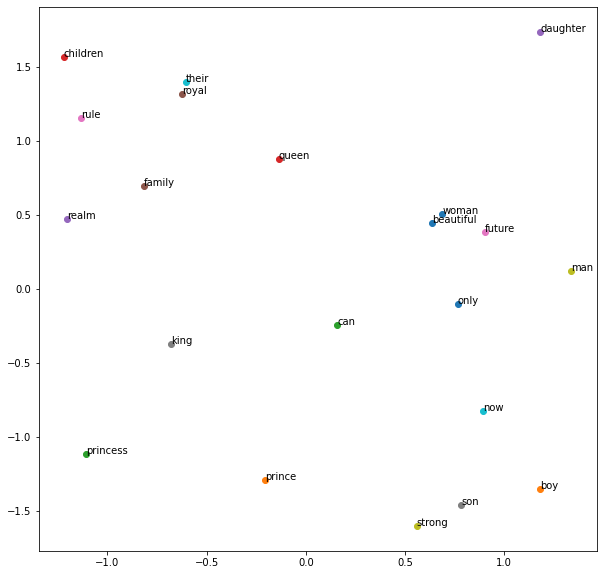

In [20]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       